In [1]:
import numpy as np
import theano 
import theano.tensor as T
%pylab inline
figsize(8, 6)

Populating the interactive namespace from numpy and matplotlib


## Baby steps

In [18]:
# declare theano variable
a = theano.tensor.lscalar() 
#a = theano.tensor.vector()

expression = 1 + 2 * a + a ** 2 

f = theano.function(
    [a], 
    expression)

In [7]:
#f(0)
result = f(np.arange(-10, 10))
result

array([  81.,   64.,   49.,   36.,   25.,   16.,    9.,    4.,    1.,
          0.,    1.,    4.,    9.,   16.,   25.,   36.,   49.,   64.,
         81.,  100.])

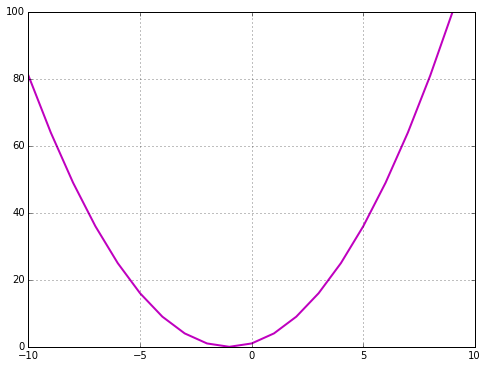

In [8]:
plot(np.arange(-10, 10), result, c='m', linewidth=2.)
grid()

In [9]:
# shared variables represent internal state
state = theano.shared(0)

i = T.iscalar('i')
accumulator = theano.function([i], 
                              state, 
                              updates=[(state, state+i)])

In [14]:
accumulator(5)

array(20)

In [15]:
state.set_value(-15)
print state.get_value()

-15


In [19]:
state.set_value(0)
f = theano.function(
    [i],
    expression,
    updates=[(state, state+i)],
    givens={
        a : state
    }
)

In [25]:
f(1)

array(36)

## Data

In [26]:
x1 = np.linspace(-1, 1, 100)
x2 = 1.5 - x1 ** 2 + np.random.normal(scale=0.2, size=100)
x3 = np.random.normal(scale=0.3, size=100)
x4 = np.random.normal(scale=0.3, size=100)

permutation = np.random.permutation(np.arange(200))
x = np.hstack((
    np.vstack((x1, x2)),
    np.vstack((x3, x4)))).T[permutation]
y = np.concatenate((
    np.zeros_like(x1),
    np.ones_like(x3)))[permutation]

# needed for pictures later
xx, yy = np.mgrid[-2:2:.01, -2:2:.01]
grid_arr = np.c_[xx.ravel(), yy.ravel()]

def plot_decision(predicts):
    probas = predicts.reshape(xx.shape)

    contour = contourf(xx, yy, probas, 25, cmap="RdBu", vmin=0, vmax=1)
    colorbar(contour)

    scatter(x[:,0], x[:, 1], c=y, s=50,
                cmap="RdBu", vmin=-.2, vmax=1.2,
                edgecolor="white", linewidth=1)
    title("Some cool decision boundary")
    grid()

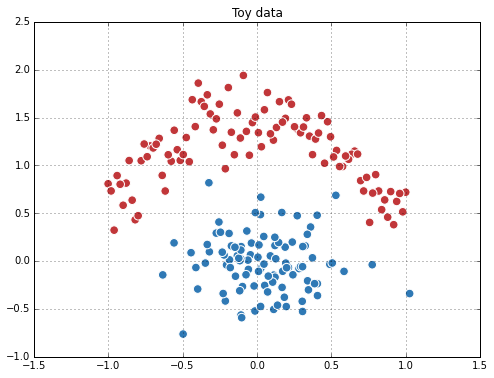

In [27]:
scatter(x[:,0], x[:, 1], c=y, s=75,
            cmap="RdBu", vmin=-.2, vmax=1.2,
            edgecolor="white", linewidth=1)
title("Toy data")
grid()

## Logistic regression

In [29]:
# allocate variables
W = theano.shared(
    value=numpy.zeros((2, 1),dtype=theano.config.floatX), 
    name='W',  
    borrow=True)

b = theano.shared(
    value=numpy.zeros((1,), dtype=theano.config.floatX),
    name='b',
    borrow=True)

X = T.matrix('X')
Y = T.imatrix('Y')
index = T.lscalar()

shared_x = theano.shared(x.astype(theano.config.floatX))
shared_y = theano.shared(y.astype(np.int32)[..., np.newaxis])

In [30]:
# define model
linear = T.dot(X, W) + b
p_y_given_x = T.nnet.sigmoid(linear)
y_pred = p_y_given_x > 0.5

cost = T.nnet.binary_crossentropy(p_y_given_x, Y).mean()

In [32]:
# give me the gradients
g_W = T.grad(cost, W)
g_b = T.grad(cost, b)

learning_rate = 0.4

In [33]:
batch_size = 4

updates = [(W,W - learning_rate * g_W),
        (b, b - 2 * learning_rate * g_b)]

train = theano.function(
    [index],
    [cost],
    updates=updates,
    givens={
        X: shared_x[index * batch_size: (index + 1) * batch_size],
        Y: shared_y[index * batch_size: (index + 1) * batch_size]
    }
)

In [34]:
## SGD is love SGD is life

for epoch_ in xrange(150):
    loss = []
    
    for iter_ in xrange(100 // batch_size):
        loss.append(train(iter_))
    
    e_loss = np.mean(loss)
    if not epoch_ % 10:
        print e_loss

0.493502346255
0.147674447402
0.128282895388
0.121076048693
0.11739237421
0.115212956857
0.113809215835
0.112853422221
0.112176679133
0.111683459472
0.111315944784
0.111037287761
0.110823034929
0.110656420058
0.110525636027


In [35]:
# p_y_given_x = T.nnet.sigmoid(T.dot(X, W) + b)

predict_proba = theano.function(
    [X],
    p_y_given_x
)

probas = predict_proba(grid_arr)


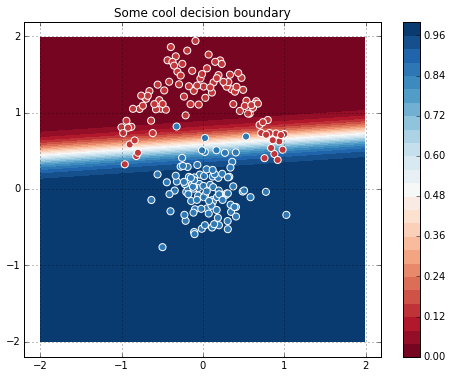

In [36]:
plot_decision(probas)

## SVM

In [66]:
# reset parameters
W.set_value(numpy.zeros((2, 1),dtype=theano.config.floatX),
        borrow=True)

b.set_value(numpy.zeros((1,), dtype=theano.config.floatX),
    borrow=True)

In [67]:
# this is the only change needed to switch to SVM

y[y == 0] = -1

linear = T.dot(X ** 51 + X ** 5 + X ** 2, W) + b

cost = T.maximum(0, 1 - linear * Y).mean()  + 2e-3 * (W ** 2).sum()





In [71]:
#learning_rate = 0.01
# this code was not changed from above!
shared_x = theano.shared(x.astype(theano.config.floatX))
shared_y = theano.shared(y.astype(np.int32)[..., np.newaxis])

g_W = T.grad(cost, W)
g_b = T.grad(cost, b)

updates = [(W,W - learning_rate * g_W),
        (b, b - 2 * learning_rate * g_b)]

train = theano.function(
    [index],
    [cost],
    updates=updates,
    givens={
        X: shared_x[index * batch_size: (index + 1) * batch_size],
        Y: shared_y[index * batch_size: (index + 1) * batch_size]
    }
)

for epoch_ in xrange(150):
    loss = []
    for iter_ in xrange(100 // batch_size):
        loss.append(train(iter_))
    e_loss = np.mean(loss)
    if not epoch_ % 10:
        print e_loss

8.07245149444
5.08135669324
2.72128208817
1.32891962237
0.694687232703
0.388649249613
0.235258656813
0.148592129988
0.165618868736
0.165583407441
0.165459371865
0.160225021915
0.160102481692
0.160319361948
0.165628919804


In [64]:
predict = theano.function(
    [X],
    linear > 0
)

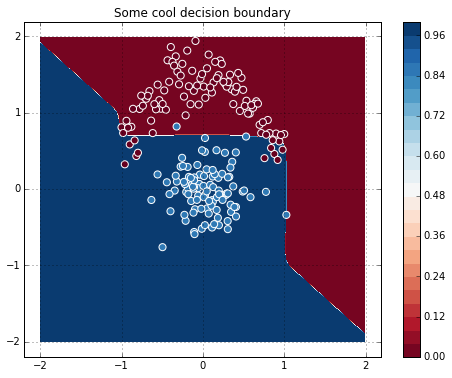

In [72]:
preds = predict(grid_arr)
plot_decision(preds)